<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter5WaveImaging/syntheticWavelengthHolography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Wavelength Holography
## David Brady
## University of Arizona
## September 2023

This notebook considers synthetic wavelength holographic imaging. We consider the impact of object structure on the reconstructed image.

## libraries

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist



## Angular Spectrum Propagation

In [2]:
def g(f,d,lam):
#
# here we assume that the pixel spacing f is 10 microns, f and lam are in units of microns
#
  numPoints=f.shape[0]
  urange=np.linspace(-1./(2*10),1./(2*10),numPoints) # in units of microns^-1
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(f)*np.fft.fftshift(np.exp(1j *2* np.pi *d*np.sqrt( 1/lam**2 - u**2 - v**2))))
  return g

#### training and validation images

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Synthetic wavelength holography

A synthetic wavelength hologram consists of the product of the diffracted field at two shifted wavelengths. The hologram is
$$G(x,y)=g(x,y,\lambda_1)g^\ast (x,y,\lambda_2)$$
Under the Fresnel approximation the diffracted field is
$$g(x,y,\lambda )=\int\int f(x',y')e^{-i\pi \frac{(x-x')^2+(y-y')^2}{\lambda R}}dx'dy'$$
where $R$ is the object range. If we assume that $$<f(x',y')f(x'',y'')>=\delta(x'-x'',y'-y'')$$ then
 $$<G(x,y)>=\int |f(x',y')|^2 e^{-i\pi \frac{(x-x')^2+(y-y')^2}{\lambda_s R}}dx'dy'$$
 where
 $$\lambda_s=\frac{\lambda_1\lambda_2}{\lambda_2-\lambda_1}$$
 is the synthetic wavelength.

 Here we attempt to reconstruct $|f(x,y)|$ for a specific example system with two different ranges.

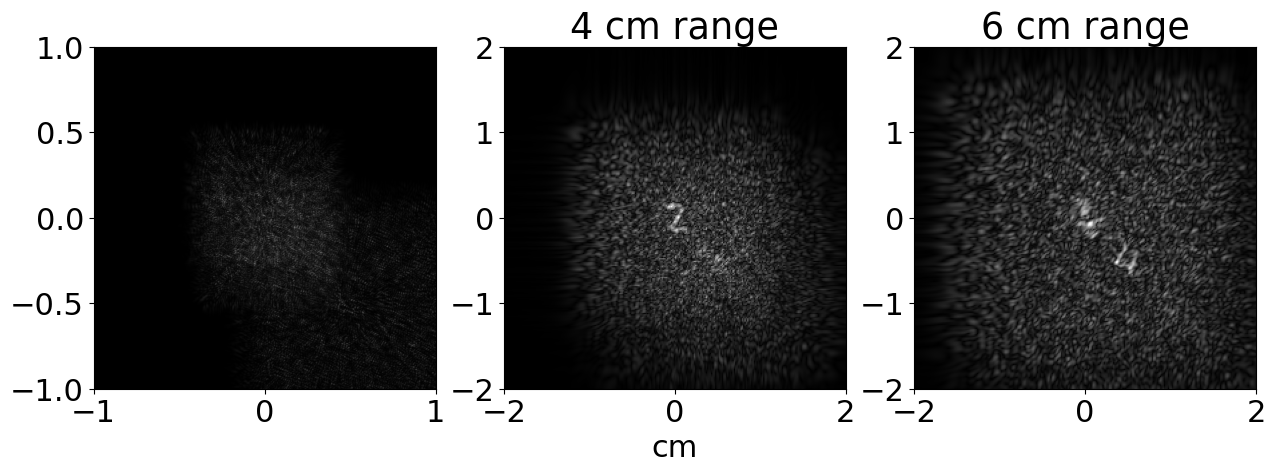

In [41]:
# diffracted field
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams.update({'font.size': 22})
N=2048
lam1=1 # wavelength in microns
lam2=1.05
slam=lam1*lam2/(lam2-lam1)
d1=40000 # in units of microns
d2=60000
f1=np.zeros([N,N]).astype('complex128') # extent of f is N* 10 microns
# insert the mnist image in the center of the field
nIm=256 # object size is nIm * 10 microns
im=cv2.resize(x_test[1036,:,:],(nIm,nIm))*np.exp(2*np.pi*1j*np.random.random((nIm,nIm)))
#im=cv2.resize(x_test[1036,:,:],(nIm,nIm))
f1[np.intc((N-nIm)/2):np.intc((N+nIm)/2),np.intc((N-nIm)/2):np.intc((N+nIm)/2)]=im
f2=np.zeros([N,N]).astype('complex128') # extent of f is N* 10 microns
im=cv2.resize(x_test[1059,:,:],(nIm,nIm))*np.exp(2*np.pi*1j*np.random.random((nIm,nIm)))
f2[np.intc((N-nIm)/2):np.intc((N+nIm)/2),np.intc((N-nIm)/2):np.intc((N+nIm)/2)]=im
f2=np.roll(np.roll(f2,250),250,axis=0)
q1=g(f1,d1,lam1)+g(f2,d2,lam1)
q2=g(f1,d1,lam2)+g(f2,d2,lam2)
holo=q1*np.conjugate(q2)
plt.subplot(1,3,1)
plt.imshow(np.abs(holo)[512:1536,512:1536],cmap='gist_gray', extent=[-1,1,-1,1])
#change sampling to 80 microns, less resolution is needed for diffraction at the synthetic wavelength
dsHolo=np.zeros((N,N)).astype('complex128')
dsHolo[np.intc(N/2-128):np.intc(N/2+128),np.intc(N/2-128):np.intc(N/2+128)]=cv2.resize(np.real(holo),(256,256))+1j*cv2.resize(np.imag(holo),(256,256))
urange=np.linspace(-1./(2*80),1./(2*80),N) # in units of microns^-1
u,v = np.meshgrid(urange,urange)
recon=np.fft.ifft2(np.fft.fft2(dsHolo)*np.fft.fftshift(np.exp(1j *np.pi *d1*slam*( u**2 + v**2))))
plt.subplot(1,3,2)
plt.imshow(np.abs(recon)[(1024-128):(1024+128),(1024-128):(1024+128)], cmap='gray', extent=[-2,2,-2,2])
plt.title('4 cm range')
plt.xlabel('cm')
recon=np.fft.ifft2(np.fft.fft2(dsHolo)*np.fft.fftshift(np.exp(1j *np.pi *d2*slam*( u**2 + v**2))))
plt.subplot(1,3,3)
plt.imshow(np.abs(recon)[(1024-128):(1024+128),(1024-128):(1024+128)], cmap='gray', extent=[-2,2,-2,2])
plt.title('6 cm range')
#

plt.savefig('syntheticLambda.pdf')
#files.download('syntheticLambda.pdf')
